**Titanic: Machine Learning from Disaster**

This playbook presents one Machine Learning model for the Kaggle competition called "Titanic: Machine Learning from Disaster". The problem consists in predicting if a passenger of the ship survirved or not based on some information about him, such as sex, age, class, etc.

The challenge can be found in: https://www.kaggle.com/c/titanic

Most of the code here was inspired in the following class notes: https://github.com/ivanovitchm/EEC1509_Machine_Learning_2019_2/tree/master/Lesson%2310

In [1]:
# Restart Runtime after installing libraries.
!pip3 install eli5

# Importing all required libraries

import eli5 

import time
import numpy as np
import pandas as pd
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

Using TensorFlow backend.


**1. Analyzing and exploring the dataset**

Kaggle provides 2 datasets for this challenge: the training (train.csv) and the testing (test.csv) datasets. 

In [2]:
# Load the datasets.
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

print("Train size: {0}\nTest size: {1}".format(train.shape,test.shape))

Train size: (891, 12)
Test size: (418, 11)


Bellow we can see how they are structured.

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In the training dataset, we can notice that the column "Survided" is our target column. Bellow we can see the number of survivors.

In [6]:
train.Survived.value_counts()

0    549
1    342
Name: Survived, dtype: int64

Furthermore, there are some numerical and non-numerical columns, with some of them with null values and this needs to be addressed later. This can be seen in the following tables and figures for both datasets.





In [7]:
# Calculate the percentage of missing values for each column in the training set.
train.isnull().sum()/train.shape[0]

PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.198653
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
Cabin          0.771044
Embarked       0.002245
dtype: float64

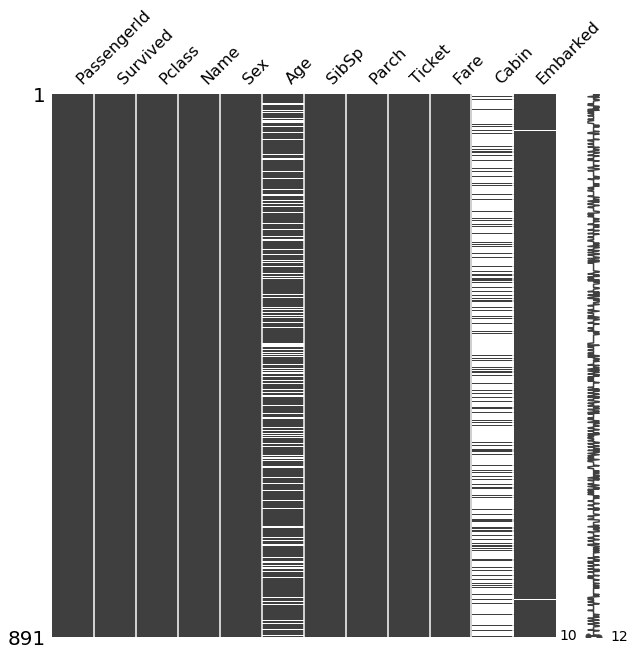

In [8]:
msno.matrix(train, figsize=(10,10))

In [9]:
test.isnull().sum()/train.shape[0]

PassengerId    0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.096521
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.001122
Cabin          0.367003
Embarked       0.000000
dtype: float64

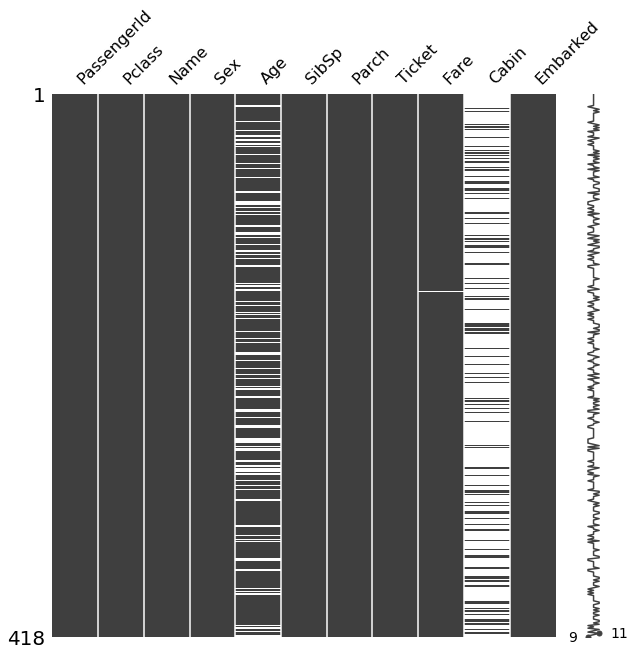

In [10]:
msno.matrix(test, figsize=(10,10))

As we can see above, in the training dataset there are 3 columns with missing values: "Age", "Cabin", and "Embarked". The same happen with the testing dataset for the columns "Age", "Fare", and "Cabin".

Now let's see how the data is distributed for some features.

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

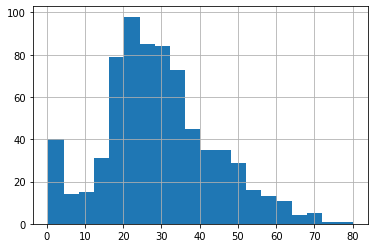

In [11]:
# Showing the distribution of age.
train.Age.hist(bins=20)
train.Age.describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

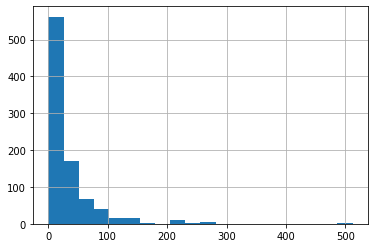

In [12]:
# Showing the distribution of fare.
train.Fare.hist(bins=20)
train.Fare.describe()

The average age for the training dataset is around 29 years old and the average ticket fare is 32, but is that true for all the passenger classes (column "Pclass")? Let's verify.

In [13]:
# Calculate the mean of other fields based on the class.
temp = train.groupby(["Pclass"]).mean()
temp


,PassengerId,Survived,Age,SibSp,Parch,Fare
Pclass,,,,,,
1,461.597222,0.629630,38.233441,0.416667,0.356481,84.154687
2,445.956522,0.472826,29.877630,0.402174,0.380435,20.662183
3,439.154786,0.242363,25.140620,0.615071,0.393075,13.675550


From the result above, we notice that the average age and fare change depending on the class, so this will be important when fixing the missing value using some stastical model, such as the mean.

Now let's analyze how the number of survivors are related to some  features.

In the chart below, we notice that passengers from class 1 and 2, mostly women, are more likely to survive than passanges from class 3.

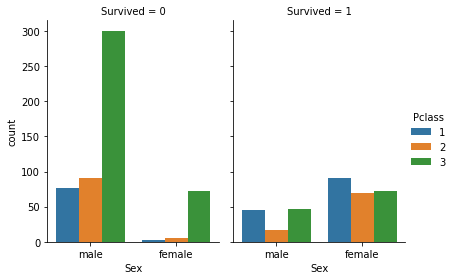

In [14]:
g = sns.catplot(x="Sex", hue="Pclass", col="Survived", data=train, kind="count", height=4, aspect=.7)

The section below will create a copy of the original training dataset (for visualization only) and will fix the missing valules for the columns seen before. 

In [15]:
# Make a copy of the original dataset.
train_aux = train.copy()

# Drop passenger id (useless).

train_aux = train_aux.drop('PassengerId', axis=1)

# Define the mean age separated by class.
c1_age_mean = train_aux.loc[train_aux.Pclass == 1, "Age"].mean()
c2_age_mean = train_aux.loc[train_aux.Pclass == 2, "Age"].mean()
c3_age_mean = train_aux.loc[train_aux.Pclass == 3, "Age"].mean()

# Fixing null values in column Age using the mean for each class.
train_aux.loc[train_aux.Pclass == 1, "Age"] = train_aux.loc[train_aux.Pclass == 1, "Age"].fillna(c1_age_mean)
train_aux.loc[train_aux.Pclass == 2, "Age"] = train_aux.loc[train_aux.Pclass == 2, "Age"].fillna(c2_age_mean)
train_aux.loc[train_aux.Pclass == 3, "Age"] = train_aux.loc[train_aux.Pclass == 3, "Age"].fillna(c3_age_mean)

# Fixing null values in column Cabin (call the missing Cabin as Unknown).
cabin_inputer = SimpleImputer(missing_values=np.nan, strategy="constant", fill_value="Unknown")
train_aux.Cabin = cabin_inputer.fit_transform(train_aux[["Cabin"]])

# Fixing null values in column Embarked (set the missing values using the mode).
emb_inputer = SimpleImputer(missing_values=np.nan, strategy="most_frequent")
train_aux.Embarked = emb_inputer.fit_transform(train_aux[["Embarked"]])

# Verifying the columns don't have any remaining null value.
train_aux.isnull().sum()

Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Ticket      0
Fare        0
Cabin       0
Embarked    0
dtype: int64

Another column that needs to be improved is the "Cabin", that contains a string and has a lot of unknown values. To simplify it, each cabin can be represented by the first letter (U will represents Unknown).

In [16]:
# Use the first char of the string to represent the Cabin.
train_aux.Cabin = train_aux.Cabin.str[0:1]
train_aux.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,U,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,U,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,U,S


By analyzing the chart below, we can see that some cabins had more survivors than others.

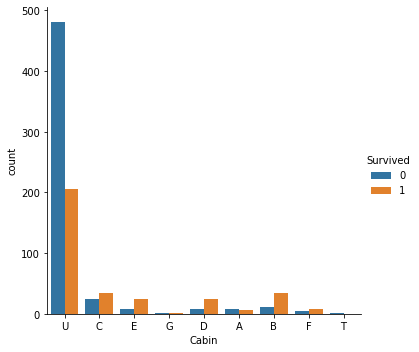

In [17]:
sns.catplot(x="Cabin", hue="Survived", data=train_aux, kind="count")

The column name can also be simplified. It's possible to realize that all the names have a prefix (Mr., Miss., Dr., etc), which represents social class of that person. So this information will be used to replace to full name.

In [18]:
train_aux.Name = train_aux.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
train_aux.Name.value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Major         2
Col           2
Mlle          2
Mme           1
Jonkheer      1
Sir           1
Capt          1
Lady          1
Countess      1
Ms            1
Don           1
Name: Name, dtype: int64

Since there are so many classes with only one title, they will be grouped as "Other".

In [0]:
# Replace class other than "Mr", "Miss", "Mrs", "Master" as Other.
train_aux.loc[~train_aux.Name.isin(["Mr", "Miss", "Mrs", "Master"]), "Name"] = "Other"

Now we can see the number of survivors based on the social class of each person.

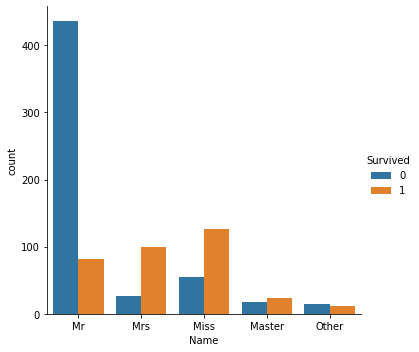

In [20]:
sns.catplot(x="Name", hue="Survived", data=train_aux, kind="count")

The last remaining column to be processed is the "Ticket". We will use the first char if it starts with a char or the word "NUM" if it's only numeric value.

In [0]:
def ticket_type(ticket):
  result = ticket[0:1]
  # Try to convert to a number. If fails, it's a string.
  try:
    int(result)
    result = 'NUM'
  except:
    pass
  return result

train_aux.Ticket = train_aux.Ticket.apply(ticket_type)

Again, we can see how the refactored column is related to the number of survivors.

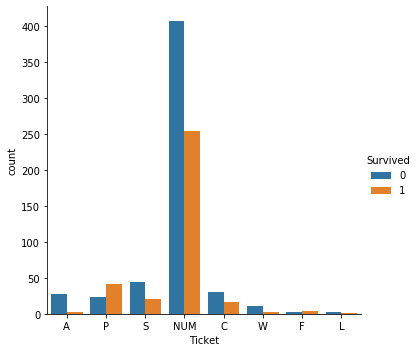

In [22]:
sns.catplot(x="Ticket", hue="Survived", data=train_aux, kind="count")

Now we will prepare the dataset to convert all categorical values to numerical values in order to be able to calculate the correlation of all features with the target column.

In [23]:
label_enc = LabelEncoder()

# Converting Sex colum to categorical.
train_aux.Sex = label_enc.fit_transform(train_aux.Sex.to_list())

# Converting Embarked colum to categorical.
train_aux.Embarked = label_enc.fit_transform(train_aux.Embarked.to_list())

# Converting Cabin to categorial.
train_aux.Cabin = label_enc.fit_transform(train_aux.Cabin.to_list())

# Converting Name to categorial.
train_aux.Name = label_enc.fit_transform(train_aux.Name.to_list())

# Converting Ticket to categorial.
train_aux.Ticket = label_enc.fit_transform(train_aux.Ticket.to_list())

train_aux.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,2,1,22.0,1,0,0,7.2500,8,2
1,1,1,3,0,38.0,1,0,5,71.2833,2,0
2,1,3,1,0,26.0,0,0,6,7.9250,8,2
3,1,1,3,0,35.0,1,0,4,53.1000,2,2
4,0,3,2,1,35.0,0,0,4,8.0500,8,2


The next step is about seeing how the columns are correlated to each other.

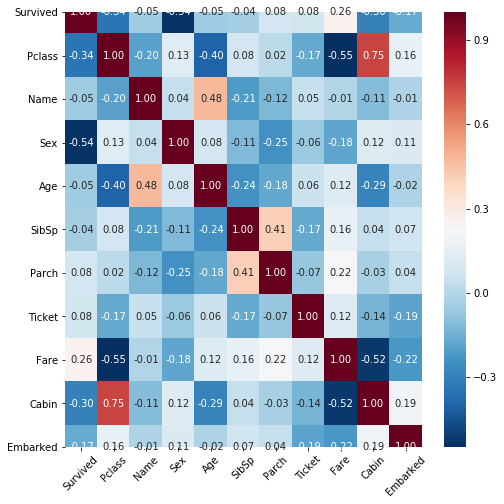

In [24]:
plt.figure(figsize = (8, 8))
sns.heatmap(train_aux.corr(), cmap=("RdBu_r"), annot=True, fmt='.2f')
plt.xticks(rotation=45) 
plt.yticks(rotation=0) 
plt.show()

From the heatmap above, we realize the columns "Sex", "Pclass", "Fare", and "Cabin" are the ones that have more correlation with the target column.

**2 - Preparing the training and test dataset**

In this section we will do some feature engineering in the original datasets based on the previous results. Moreover, we will reduce the number of ranges of "Age" and "Fare", as well create other columns based on information of the existing ones.

The first step is to apply the same strategies applied before (it was done by using a temporary copy of the original dataset). 



In [0]:
# These are the datasets to be used in the model.
train_p = train.copy()
test_p = test.copy()

# Drop passenger id (useless).
train_p = train_p.drop('PassengerId', axis=1)
test_p = test_p.drop('PassengerId', axis=1)

# Fixing null values in column Age using the mean for each Pclass.
train_p.loc[train_p.Pclass == 1, "Age"] = train_p.loc[train_p.Pclass == 1, "Age"].fillna(int(train_p.loc[train_p.Pclass == 1, "Age"].mean()))
train_p.loc[train_p.Pclass == 2, "Age"] = train_p.loc[train_p.Pclass == 2, "Age"].fillna(int(train_p.loc[train_p.Pclass == 2, "Age"].mean()))
train_p.loc[train_p.Pclass == 3, "Age"] = train_p.loc[train_p.Pclass == 3, "Age"].fillna(int(train_p.loc[train_p.Pclass == 3, "Age"].mean()))

test_p.loc[test_p.Pclass == 1, "Age"] = test_p.loc[test_p.Pclass == 1, "Age"].fillna(int(test_p.loc[test_p.Pclass == 1, "Age"].mean()))
test_p.loc[test_p.Pclass == 2, "Age"] = test_p.loc[test_p.Pclass == 2, "Age"].fillna(int(test_p.loc[test_p.Pclass == 2, "Age"].mean()))
test_p.loc[test_p.Pclass == 3, "Age"] = test_p.loc[test_p.Pclass == 3, "Age"].fillna(int(test_p.loc[test_p.Pclass == 3, "Age"].mean()))

# Fixing null values in column Cabin.
cabin_inputer = SimpleImputer(missing_values=np.nan, strategy="constant", fill_value="Unknown")
train_p.Cabin = cabin_inputer.fit_transform(train_p[["Cabin"]])
test_p.Cabin = cabin_inputer.fit_transform(test_p[["Cabin"]])

# Fixing null values in column Embarked (missing only in train).
emb_inputer = SimpleImputer(missing_values=np.nan, strategy="most_frequent")
train_p.Embarked = emb_inputer.fit_transform(train_p[["Embarked"]])

# Fixing null values in Fare (missing only in test).
fare_inputer = SimpleImputer(missing_values=np.nan, strategy="most_frequent")
test_p.Fare = fare_inputer.fit_transform(test_p[["Fare"]])

# Processing colums with text.
train_p.Cabin = train_p.Cabin.str[0:1]
test_p.Cabin = test_p.Cabin.str[0:1]

train_p.Name = train_p.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
train_p.loc[~train_p.Name.isin(["Mr", "Miss", "Mrs", "Master", "Dr", "Rev"]), "Name"] = "Other"
test_p.Name = test_p.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
test_p.loc[~test_p.Name.isin(["Mr", "Miss", "Mrs", "Master", "Dr", "Rev"]), "Name"] = "Other"

train_p.Ticket = train_p.Ticket.apply(ticket_type)
test_p.Ticket = test_p.Ticket.apply(ticket_type)

In [26]:
train_p.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,Mr,male,22.0,1,0,A,7.2500,U,S
1,1,1,Mrs,female,38.0,1,0,P,71.2833,C,C
2,1,3,Miss,female,26.0,0,0,S,7.9250,U,S
3,1,1,Mrs,female,35.0,1,0,NUM,53.1000,C,S
4,0,3,Mr,male,35.0,0,0,NUM,8.0500,U,S


The following is step is about creating new features based on the existing ones. We will sum the number of siblings, spouses, children, and parents and call the result as the number of relatives. Also, if this number is 0, we will consider that the passenger was traveling alone.

In [0]:
# Dealing with number of siblings/ spouses and parentes/ children.
train_p["NumRelatives"] = train_p["SibSp"] + train_p["Parch"]
test_p["NumRelatives"] = test_p["SibSp"] + test_p["Parch"]

# Defining if the passenger was travelling alone.
train_p["Alone"] = "Yes"
train_p.loc[train_p["NumRelatives"] > 0, "Alone"] = "No"
test_p["Alone"] = "Yes"
test_p.loc[test_p["NumRelatives"] > 0, "Alone"] = "No"

# Creating categories for Age and Fare.
age_points = [0, 18, 30, 60, 100]
age_names = ["Child", "YoungAdult", "Adult", "Senior"]
train_p["AgeCat"] = pd.cut(train_p["Age"], age_points, labels=age_names)
test_p["AgeCat"] = pd.cut(test_p["Age"], age_points, labels=age_names)

fare_points = [-1, 15, 60, 300, 1000]
fare_names = ["Cheap",  "Regular", "Business", "First"]
train_p["FareCat"] = pd.cut(train_p["Fare"], fare_points, labels=fare_names)
test_p["FareCat"] = pd.cut(test_p["Fare"], fare_points, labels=fare_names)

Now let's see how the new categories are related to the number of survivors.

In [28]:
train_p.AgeCat.value_counts()

YoungAdult    417
Adult         313
Child         139
Senior         22
Name: AgeCat, dtype: int64

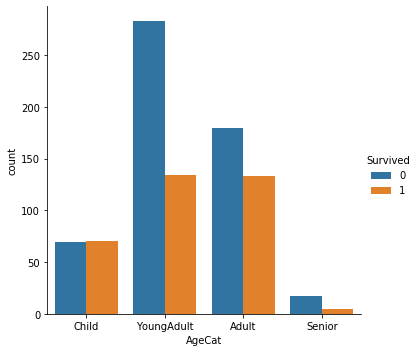

In [29]:
sns.catplot(x="AgeCat", hue="Survived", data=train_p, kind="count")

In [30]:
train_p.FareCat.value_counts()

Cheap       458
Regular     311
Business    119
First         3
Name: FareCat, dtype: int64

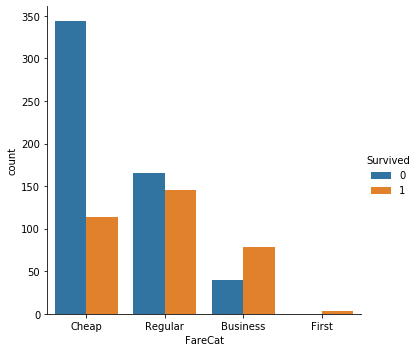

In [31]:
sns.catplot(x="FareCat", hue="Survived", data=train_p, kind="count")

The first chart above shows that child and young adults are more likely to survive. The second one shows that the passengers from most expensive classes survived more than the ones from the cheaper classes.

Let's see how the dataset is looking like now.

In [32]:
train_p.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,NumRelatives,Alone,AgeCat,FareCat
0,0,3,Mr,male,22.0,1,0,A,7.2500,U,S,1,No,YoungAdult,Cheap
1,1,1,Mrs,female,38.0,1,0,P,71.2833,C,C,1,No,Adult,Business
2,1,3,Miss,female,26.0,0,0,S,7.9250,U,S,0,Yes,YoungAdult,Cheap
3,1,1,Mrs,female,35.0,1,0,NUM,53.1000,C,S,1,No,Adult,Regular
4,0,3,Mr,male,35.0,0,0,NUM,8.0500,U,S,0,Yes,Adult,Cheap


The goal now is to convert the category features to numerical values and finally to scale the values (normalization). This is going to be done by using one hot encoding. Nevertheless, before doing this we need to improve the Pclass feature, because it's a kind of categorical column although the column itself is represented as numeric.

In [33]:
train_p['Pclass'] = train_p['Pclass'].map({1: 'First', 2: 'Second', 3: 'Third'})
test_p['Pclass'] = test_p['Pclass'].map({1: 'First', 2: 'Second', 3: 'Third'})

# Viewing the new Pclass.
train_p[["Pclass"]].head()

,Pclass
0,Third
1,First
2,Third
3,First
4,Third


With the columns ready, we can separate the features from the target column and remove redundant columns.

In [0]:
# Separating features of the target column.
target = train_p["Survived"]
train_p = train_p.drop("Survived", axis=1)

# Removing redundant columns.
train_p = train_p.drop(labels=["SibSp", "Parch",], axis=1)
test_p = test_p.drop(labels=["SibSp", "Parch",], axis=1)

Finally, we can encode all categorial features and normalize all numerical columns.

In [0]:
# Encode the Ticket and Cabin using regular LabelEncode bacause they have so many categories.
train_p[["Ticket"]] = train_p[["Ticket"]].apply(lambda col: label_enc.fit_transform(col))
test_p[["Ticket"]] = test_p[["Ticket"]].apply(lambda col: label_enc.fit_transform(col))

train_p[["Cabin"]] = train_p[["Cabin"]].apply(lambda col: label_enc.fit_transform(col))
test_p[["Cabin"]] = test_p[["Cabin"]].apply(lambda col: label_enc.fit_transform(col))

# Join datasets to create the all the columns properly (without doing this, the test dataset would have less columns).
temp = pd.concat([train_p, test_p])

# Get all categorical and numerical columns.
categorical_features = temp.select_dtypes(include=["object", "category"]).columns
numerical_features = temp.select_dtypes(include=["int64","float64"]).columns

# Convert the categorical columns using one hot encoding.
temp = pd.get_dummies(temp, drop_first=True, columns=categorical_features)

# le = LabelEncoder()
# temp[categorical_features] = temp[categorical_features].apply(lambda col: le.fit_transform(col))

# Separate the datasets again.
train_p = temp.iloc[:891].copy()
test_p = temp.iloc[891:].copy()

# Normalize the numerical columns.
scaler = StandardScaler()
train_p[train_p.columns] = scaler.fit_transform(train_p[train_p.columns])
test_p[test_p.columns] = scaler.fit_transform(test_p[test_p.columns])

Final version of train and test datasets.

In [36]:
train_p.head()

,Age,Ticket,Fare,Cabin,NumRelatives,Pclass_Second,Pclass_Third,Name_Master,Name_Miss,Name_Mr,Name_Mrs,Name_Other,Name_Rev,Sex_male,Embarked_Q,Embarked_S,Alone_Yes,AgeCat_YoungAdult,AgeCat_Adult,AgeCat_Senior,FareCat_Regular,FareCat_Business,FareCat_First
0,-0.549259,-3.201444,-0.502445,0.522067,0.059160,-0.510152,0.902587,-0.216803,-0.506655,0.850532,-0.403962,-0.126347,-0.082339,0.737695,-0.307562,0.615838,-1.231645,1.066157,-0.735882,-0.159111,-0.732261,-0.392613,-0.058124
1,0.662445,0.846933,0.786845,-1.917594,0.059160,-0.510152,-1.107926,-0.216803,-0.506655,-1.175735,2.475480,-0.126347,-0.082339,-1.355574,-0.307562,-1.623803,-1.231645,-0.937948,1.358913,-0.159111,-0.732261,2.547037,-0.058124
2,-0.246333,1.656609,-0.488854,0.522067,-0.560975,-0.510152,0.902587,-0.216803,1.973729,-1.175735,-0.403962,-0.126347,-0.082339,-1.355574,-0.307562,0.615838,0.811922,1.066157,-0.735882,-0.159111,-0.732261,-0.392613,-0.058124
3,0.435251,0.037258,0.420730,-1.917594,0.059160,-0.510152,-1.107926,-0.216803,-0.506655,-1.175735,2.475480,-0.126347,-0.082339,-1.355574,-0.307562,0.615838,-1.231645,-0.937948,1.358913,-0.159111,1.365632,-0.392613,-0.058124
4,0.435251,0.037258,-0.486337,0.522067,-0.560975,-0.510152,0.902587,-0.216803,-0.506655,0.850532,-0.403962,-0.126347,-0.082339,0.737695,-0.307562,0.615838,0.811922,-0.937948,1.358913,-0.159111,-0.732261,-0.392613,-0.058124


In [37]:
test_p.head()

,Age,Ticket,Fare,Cabin,NumRelatives,Pclass_Second,Pclass_Third,Name_Master,Name_Miss,Name_Mr,Name_Mrs,Name_Other,Name_Rev,Sex_male,Embarked_Q,Embarked_S,Alone_Yes,AgeCat_YoungAdult,AgeCat_Adult,AgeCat_Senior,FareCat_Regular,FareCat_Business,FareCat_First
0,0.396252,0.069338,-0.497063,0.500456,-0.553443,-0.534933,0.957826,-0.229993,-0.478969,0.861201,-0.456172,-0.098295,-0.069338,0.755929,2.843757,-1.350676,0.807573,-1.069388,1.488417,-0.164399,-0.709646,-0.413362,-0.04897
1,1.362608,0.069338,-0.511926,0.500456,0.105643,-0.534933,0.957826,-0.229993,-0.478969,-1.161169,2.192158,-0.098295,-0.069338,-1.322876,-0.351647,0.740370,-1.238278,-1.069388,1.488417,-0.164399,-0.709646,-0.413362,-0.04897
2,2.522236,0.069338,-0.463754,0.500456,-0.553443,1.869391,-1.044031,-0.229993,-0.478969,0.861201,-0.456172,-0.098295,-0.069338,0.755929,2.843757,-1.350676,0.807573,-1.069388,-0.671855,6.082763,-0.709646,-0.413362,-0.04897
3,-0.183561,0.069338,-0.482127,0.500456,-0.553443,-0.534933,0.957826,-0.229993,-0.478969,0.861201,-0.456172,-0.098295,-0.069338,0.755929,-0.351647,0.740370,0.807573,0.935115,-0.671855,-0.164399,-0.709646,-0.413362,-0.04897
4,-0.570104,0.069338,-0.417151,0.500456,0.764728,-0.534933,0.957826,-0.229993,-0.478969,-1.161169,2.192158,-0.098295,-0.069338,-1.322876,-0.351647,0.740370,-1.238278,0.935115,-0.671855,-0.164399,-0.709646,-0.413362,-0.04897


**3 - Creating and training the model**

Firstly, we will train a RandomForest in order to analyze the feature importance.

In [38]:
seed = 42
num_folds = 10
scoring = {'Accuracy': make_scorer(accuracy_score)}

kfold = StratifiedKFold(n_splits=num_folds,random_state=seed)
rfc = RandomForestClassifier(oob_score = True, bootstrap = True)

# Creating the traininig and testing sets.
X_train, X_test, y_train, y_test = train_test_split(train_p,
                                                    target,
                                                    test_size=0.20,
                                                    random_state=seed,
                                                    shuffle=True,
                                                    stratify=target)

search_space = {
    'n_estimators': [20, 50, 100],
    'min_samples_split': [2, 4, 8],
    'min_samples_leaf': [1, 2, 4],
}

grid = GridSearchCV(estimator=rfc, 
                    param_grid=search_space,
                    cv=kfold,
                    scoring=scoring,
                    return_train_score=True,
                    n_jobs=-1,
                    refit="Accuracy")


# Train the RandomForest.
best_model = grid.fit(X_train, y_train)

estimator = best_model.best_estimator_
print(estimator)

# Showing first result.
predict = estimator.predict(X_test)
print(accuracy_score(y_test, predict))
print(confusion_matrix(y_test, predict))
print(classification_report(y_test, predict))

# # Utilizando a biblioteca ELI5, exibe a feature importance da RandomForest.
eli5.show_weights(estimator, show_feature_values=True, feature_names=X_train.columns.to_list())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)
0.8212290502793296
[[97 13]
 [19 50]]
              precision    recall  f1-score   support

           0       0.84      0.88      0.86       110
           1       0.79      0.72      0.76        69

    accuracy                           0.82       179
   macro avg       0.81      0.80      0.81       179
weighted avg       0.82      0.82      0.82       179



/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Weight,Feature
0.1981 ± 0.3452,Name_Mr
0.1366 ± 0.3453,Sex_male
0.1326 ± 0.1199,Fare
0.0873 ± 0.1153,Age
0.0656 ± 0.1746,Name_Miss
0.0643 ± 0.1266,Pclass_Third
0.0633 ± 0.1777,Cabin
0.0596 ± 0.1811,Name_Mrs
0.0509 ± 0.0741,NumRelatives
0.0221 ± 0.0440,Embarked_S


As we can see in the table above, the features related to the social class, the fare, the sex, and the age have the most importance during the classification. We will use this results to suggest different values of K for the SelectKBest during the grid search below. 

In [39]:
train_final = train_p
test_final = test_p

# Split the training dataset for the validation of the model.
X_train, X_test, y_train, y_test = train_test_split(train_final,
                                                    target,
                                                    test_size=0.20,
                                                    random_state=seed,
                                                    shuffle=True,
                                                    stratify=target)
# Piple line using the SelectKBest and classifier.
pipe = Pipeline(
    steps=[
           ('fs', SelectKBest()),
           ('clf', RandomForestClassifier())
    ]
)

# Search space.
search_space = [
  {"clf":[RandomForestClassifier()],
    "clf__n_estimators": [50, 100],
    "clf__criterion": ["entropy"],
    "clf__max_leaf_nodes": [64],
    "clf__min_samples_split": [4],
    "clf__random_state": [seed],
    "fs__k": [4, 10, 'all'],
    },
  {"clf":[XGBClassifier()],
    "clf__n_estimators": [50, 100],
    "clf__max_depth": [4],
    "clf__learning_rate": [0.001, 0.01, 0.1],
    "clf__random_state": [seed],
    "clf__subsample": [1.0],
    "clf__colsample_bytree": [1.0],
    "fs__k": [4, 10, 'all'],
    },
]

# Create the grid search.
grid = GridSearchCV(estimator=pipe, 
                    param_grid=search_space,
                    cv=kfold,
                    scoring=scoring,
                    return_train_score=True,
                    n_jobs=-1,
                    refit="Accuracy")

# Run the grid search.
tmp = time.time()
best_model = grid.fit(X_train, y_train)
print("CPU Training Time: %s seconds" % (str(time.time() - tmp))) 

CPU Training Time: 15.555577039718628 seconds


In [40]:
print("Best model: %f using %s" % (best_model.best_score_, best_model.best_params_))

result = pd.DataFrame(best_model.cv_results_)
result.head()

Best model: 0.832865 using {'clf': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=64,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False), 'clf__criterion': 'entropy', 'clf__max_leaf_nodes': 64, 'clf__min_samples_split': 4, 'clf__n_estimators': 100, 'clf__random_state': 42, 'fs__k': 'all'}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf,param_clf__criterion,param_clf__max_leaf_nodes,param_clf__min_samples_split,param_clf__n_estimators,param_clf__random_state,param_fs__k,param_clf__colsample_bytree,param_clf__learning_rate,param_clf__max_depth,param_clf__subsample,params,split0_test_Accuracy,split1_test_Accuracy,split2_test_Accuracy,split3_test_Accuracy,split4_test_Accuracy,split5_test_Accuracy,split6_test_Accuracy,split7_test_Accuracy,split8_test_Accuracy,split9_test_Accuracy,mean_test_Accuracy,std_test_Accuracy,rank_test_Accuracy,split0_train_Accuracy,split1_train_Accuracy,split2_train_Accuracy,split3_train_Accuracy,split4_train_Accuracy,split5_train_Accuracy,split6_train_Accuracy,split7_train_Accuracy,split8_train_Accuracy,split9_train_Accuracy,mean_train_Accuracy,std_train_Accuracy
0,0.110981,0.003324,0.008400,0.000336,"(DecisionTreeClassifier(class_weight=None, cri...",entropy,64,4,50,42,4,NaN,NaN,NaN,NaN,{'clf': (DecisionTreeClassifier(class_weight=N...,0.722222,0.750000,0.791667,0.774648,0.802817,0.802817,0.859155,0.774648,0.704225,0.742857,0.772472,0.042758,18,0.796875,0.800000,0.789062,0.812793,0.798752,0.809672,0.803432,0.790952,0.804992,0.816199,0.802273,0.008470
1,0.128531,0.001396,0.009313,0.001347,"(DecisionTreeClassifier(class_weight=None, cri...",entropy,64,4,50,42,10,NaN,NaN,NaN,NaN,{'clf': (DecisionTreeClassifier(class_weight=N...,0.763889,0.777778,0.847222,0.746479,0.816901,0.845070,0.873239,0.816901,0.788732,0.800000,0.807584,0.037981,9,0.901563,0.907813,0.903125,0.912637,0.914197,0.907956,0.901716,0.904836,0.904836,0.909657,0.906834,0.004169
2,0.135143,0.001556,0.009080,0.000438,"(DecisionTreeClassifier(class_weight=None, cri...",entropy,64,4,50,42,all,NaN,NaN,NaN,NaN,{'clf': (DecisionTreeClassifier(class_weight=N...,0.750000,0.861111,0.875000,0.732394,0.845070,0.816901,0.901408,0.845070,0.802817,0.842857,0.827247,0.050528,3,0.928125,0.935937,0.915625,0.925117,0.925117,0.923557,0.920437,0.918877,0.929797,0.931464,0.925405,0.005838
3,0.212538,0.003287,0.015953,0.002910,"(DecisionTreeClassifier(class_weight=None, cri...",entropy,64,4,100,42,4,NaN,NaN,NaN,NaN,{'clf': (DecisionTreeClassifier(class_weight=N...,0.722222,0.750000,0.791667,0.746479,0.802817,0.802817,0.859155,0.774648,0.760563,0.742857,0.775281,0.037907,17,0.796875,0.800000,0.789062,0.812793,0.798752,0.809672,0.803432,0.790952,0.803432,0.816199,0.802117,0.008433
4,0.264092,0.012285,0.016929,0.002863,"(DecisionTreeClassifier(class_weight=None, cri...",entropy,64,4,100,42,10,NaN,NaN,NaN,NaN,{'clf': (DecisionTreeClassifier(class_weight=N...,0.750000,0.777778,0.847222,0.746479,0.816901,0.830986,0.873239,0.816901,0.788732,0.814286,0.806180,0.038679,11,0.909375,0.906250,0.906250,0.912637,0.911076,0.911076,0.906396,0.901716,0.904836,0.901869,0.907148,0.003617


Evaluting the model with the test set.

In [41]:
prediction = best_model.best_estimator_.predict(X_test)
print(accuracy_score(y_test, prediction))
print(confusion_matrix(y_test, prediction))
print(classification_report(y_test, prediction))

0.8324022346368715
[[98 12]
 [18 51]]
              precision    recall  f1-score   support

           0       0.84      0.89      0.87       110
           1       0.81      0.74      0.77        69

    accuracy                           0.83       179
   macro avg       0.83      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179



The best model selected above was a random forest, with the following parameters:



```
{'clf': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=64,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False), 'clf__criterion': 'entropy', 'clf__max_leaf_nodes': 64, 'clf__min_samples_split': 4, 'clf__n_estimators': 100, 'clf__random_state': 42, 'fs__k': 'all'}
```



This random forest could reform really well on the validation set for the model (X_test, y_test) - with data that the model has never seen -, so that it could reach a score of 0.83240. This is almost the same value of the score for the training set itself, which was 0.83286. Thus, this shows that the model is not overfitted nor underfitted.

**4 - Final Result**

After submitting the file above to Kaggle, it was possible to reach a score of 0.80382, what is a good result compared to the performance during the training of the model.

In [0]:
predict_final = best_model.best_estimator_.predict(test_final)

holdout_ids = test["PassengerId"]
submission_df = {"PassengerId": holdout_ids,
                 "Survived": predict_final}
submission = pd.DataFrame(submission_df)

submission.to_csv("submission.csv", index=False)